Hello

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For aesthetical reasons
import scipy.signal as sg  # Package for signal analysis
import h5py  # Package for reading HDF5-files
import datetime as dt  # To get aesthetical date formats
import matplotlib.transforms as transforms  # For use in construction of the variance matrix

from scipy import stats, fft  # Used for 2D binned statistics
from matplotlib.patches import Ellipse  # Our patch for plotting the variance matrix
from pandas.plotting import register_matplotlib_converters  # So that matplotlib understands datetime formats
register_matplotlib_converters()


sns.set()
sns.set_style("whitegrid")  # Choosing which style to use for our plots

We begin by reading in data.

In [14]:
datadir = "../data/"
with h5py.File(datadir + "bravo94.mat",'r') as file:
    # Looking at contents of file
    print(file.keys())
    # Finding the variables contained in the key
    variables = list(file.get("bravo94/rcm"))
    print(variables)

    # Storing the variables in a dictionary
    data = {}
    for i in variables:
        data[i] = np.array(file.get(f"bravo94/rcm/{i}")).squeeze()  # removes excessive dims

    # Convert a complex tuple (real, imag) to a complex number a + jb
    cv = np.zeros((data["cv"].shape[0], data["cv"].shape[1]), dtype=complex)
    for i in range(len(data["cv"])):
        for j in range(len(data["cv"][0])):
            cv[i][j] = data["cv"][i][j][0] + 1j*data["cv"][i][j][1]
    data["cv"] = cv

    # Convert matlab datenum format to a datetime object for aesthetics
    num = []
    for i in data["num"]:
        num.append(dt.datetime.fromordinal(int(i)) + dt.timedelta(days=i%1) - dt.timedelta(days = 366))
    data["num"] = np.array(num)

<KeysViewHDF5 ['#refs#', 'bravo94']>
['cv', 'depths', 'description', 'num', 'p', 'th']


Lets look closer at the spectrum of the sixth

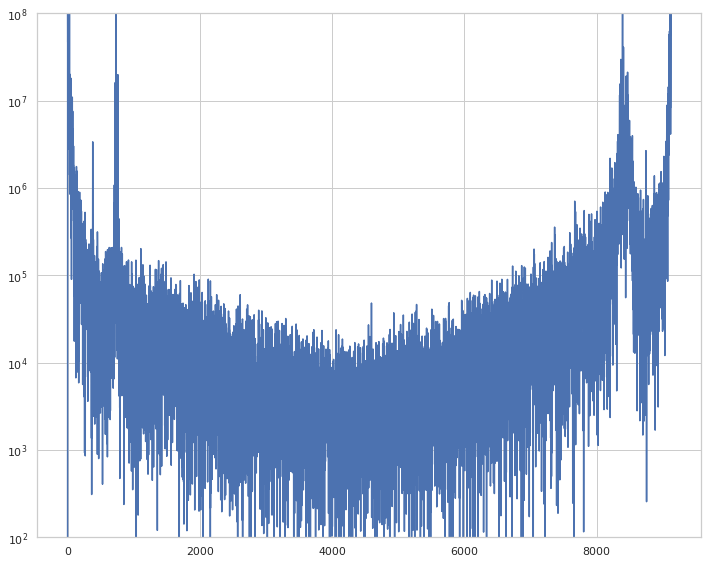

In [21]:
cv6 = data["cv"][5]
cv6_centered = cv6 - np.mean(cv6)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.semilogy(np.abs(fft(cv6_centered))**2)
ax.set_ylim(1e2, 1e8)
fig.tight_layout()

Lets take a closer look at the eastward velocity

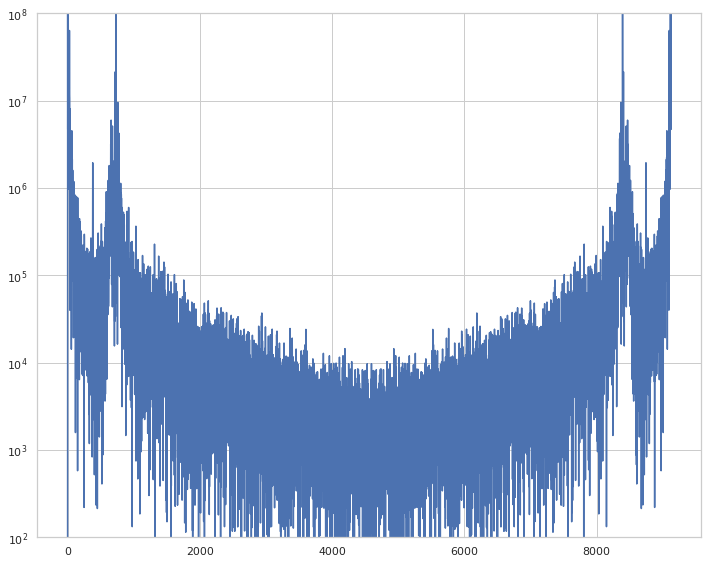

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.semilogy(np.abs(fft(cv6_centered.real))**2)
ax.set_ylim(1e2, 1e8)
fig.tight_layout()

Now for one sided spectra. sg.periodogram returns a two sided spectrum for complex values, but we can retrieve the one sided spectra using some numpy functions.

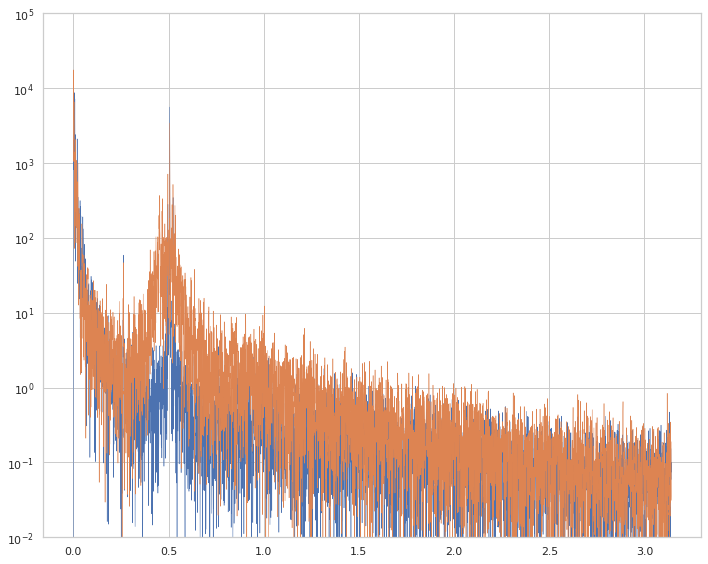

In [87]:
f, p = sg.periodogram(cv6_centered, fs=2*np.pi)

# method 1: Cutting arrays at the midldle. We have to flip p for negative freq when plotting
fsplit = np.array_split(f, 2)
psplit = np.array_split(p, 2)

# method 2: Extracts neg and pos freqs using boolean indexing. We don't need info about array order
fpos = f[f >= 0]
fneg = np.abs(f[f < 0])
ppos = p[np.where(f >= 0)]
pneg = p[np.where(f < 0)]


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

#ax.semilogy(fsplit[0], psplit[0], linewidth=0.5)
#ax.semilogy(fsplit[0], np.flip(psplit[1]), linewidth=0.5)  # Flipping negative freq p

ax.semilogy(fpos, ppos, linewidth=0.5)
ax.semilogy(fneg, pneg, linewidth=0.5)
ax.set_ylim(1e-2, 1e5)
fig.tight_layout()

We now want to use another sampling frequency in units of inverse hour. Using only one of the methods above, we find the spectrum again.

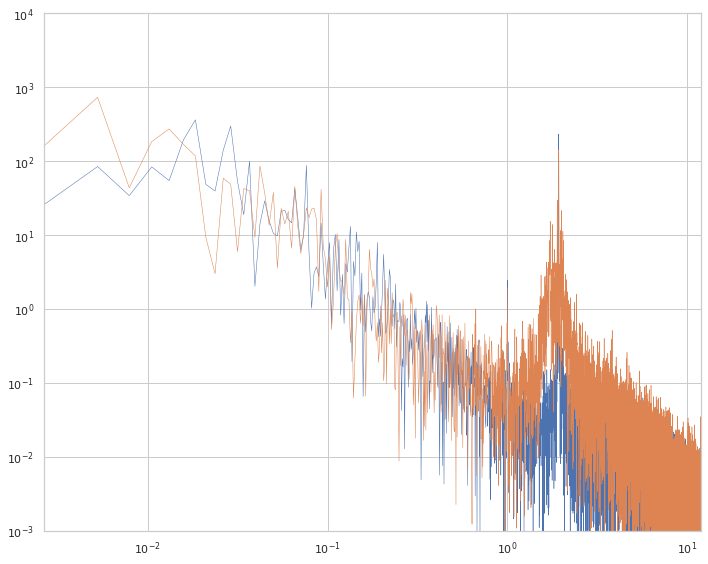

In [93]:
f, p = sg.periodogram(cv6_centered, fs=24*2*np.pi)

fpos = f[f >= 0]
fneg = np.abs(f[f < 0])
ppos = p[np.where(f >= 0)]
pneg = p[np.where(f < 0)]


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.loglog(fpos/(2*np.pi), ppos, linewidth=0.5)
ax.loglog(fneg/(2*np.pi), pneg, linewidth=0.5)
ax.set_ylim(1e-3, 1e4)
ax.set_xlim(fpos[1]/(2*np.pi), fpos[-1]/(2*np.pi))
fig.tight_layout()